In [1]:
import sys
#sys.path.append("C:/Users/Surface/Documents/repos/playground")
sys.path.append("/home/peterhacker/Documents/phRepo/playground")

from Oceanmodel.policy_ve import *
from Oceanmodel.stateupdates_ve import *
from Oceanmodel.engine import *



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (832, 11, 4, 10)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0]
SubsetIDs: [0, 0, 0, 0]
Ns       : [0, 1, 2, 3]
ExpIDs   : [0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 110.17s


In [2]:
# Analysis and plotting modules
import pandas as pd
import numpy as np
# import plotly
import matplotlib.pyplot as plt

In [3]:
# df for monte carlo plots
last_substep = max(simulation_result.substep)

df_p = simulation_result.copy()
df_p = df_p[df_p.substep == last_substep]
df_p['ve_balance'] = df_p.apply(lambda x: sum([x['ve_accounts'][acct].vebalance for acct in x['ve_accounts'].keys()]), axis=1)
df_p['locked_supply'] = df_p.apply(lambda x: sum([x['ve_accounts'][acct].locked for acct in x['ve_accounts'].keys()]), axis=1)
df_p['active_pct'] = df_p.apply(lambda x: sum([x['votes'][asset] for asset in x['votes'].keys()]), axis=1)
df_p['pct_locked'] = df_p['locked_supply'] / (df_p['locked_supply'] + df_p['ocean_unlocked_supply'])
df_p['dcv'] = df_p.apply(lambda x: sum([x['data_assets'][asset].dataconsumevolume for asset in x['data_assets'].keys()]), axis=1)
df_p['Passive_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_df_passive']/x['locked_supply']/52) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
df_p['Active_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_df_active']/(x['active_pct']*x['locked_supply'])/52) ** 52 - 1 if x['locked_supply'] != 0 and x['active_pct'] != 0 else 0, axis=1)
df_p['Fees_APY'] = df_p.apply(lambda x: (1 + x['rewards_distributed_fees']/x['locked_supply']/52) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
df_p['Agg_APY'] = df_p.apply(lambda x: (1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_df_active'] + x['rewards_distributed_fees'])/x['locked_supply']/52) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)



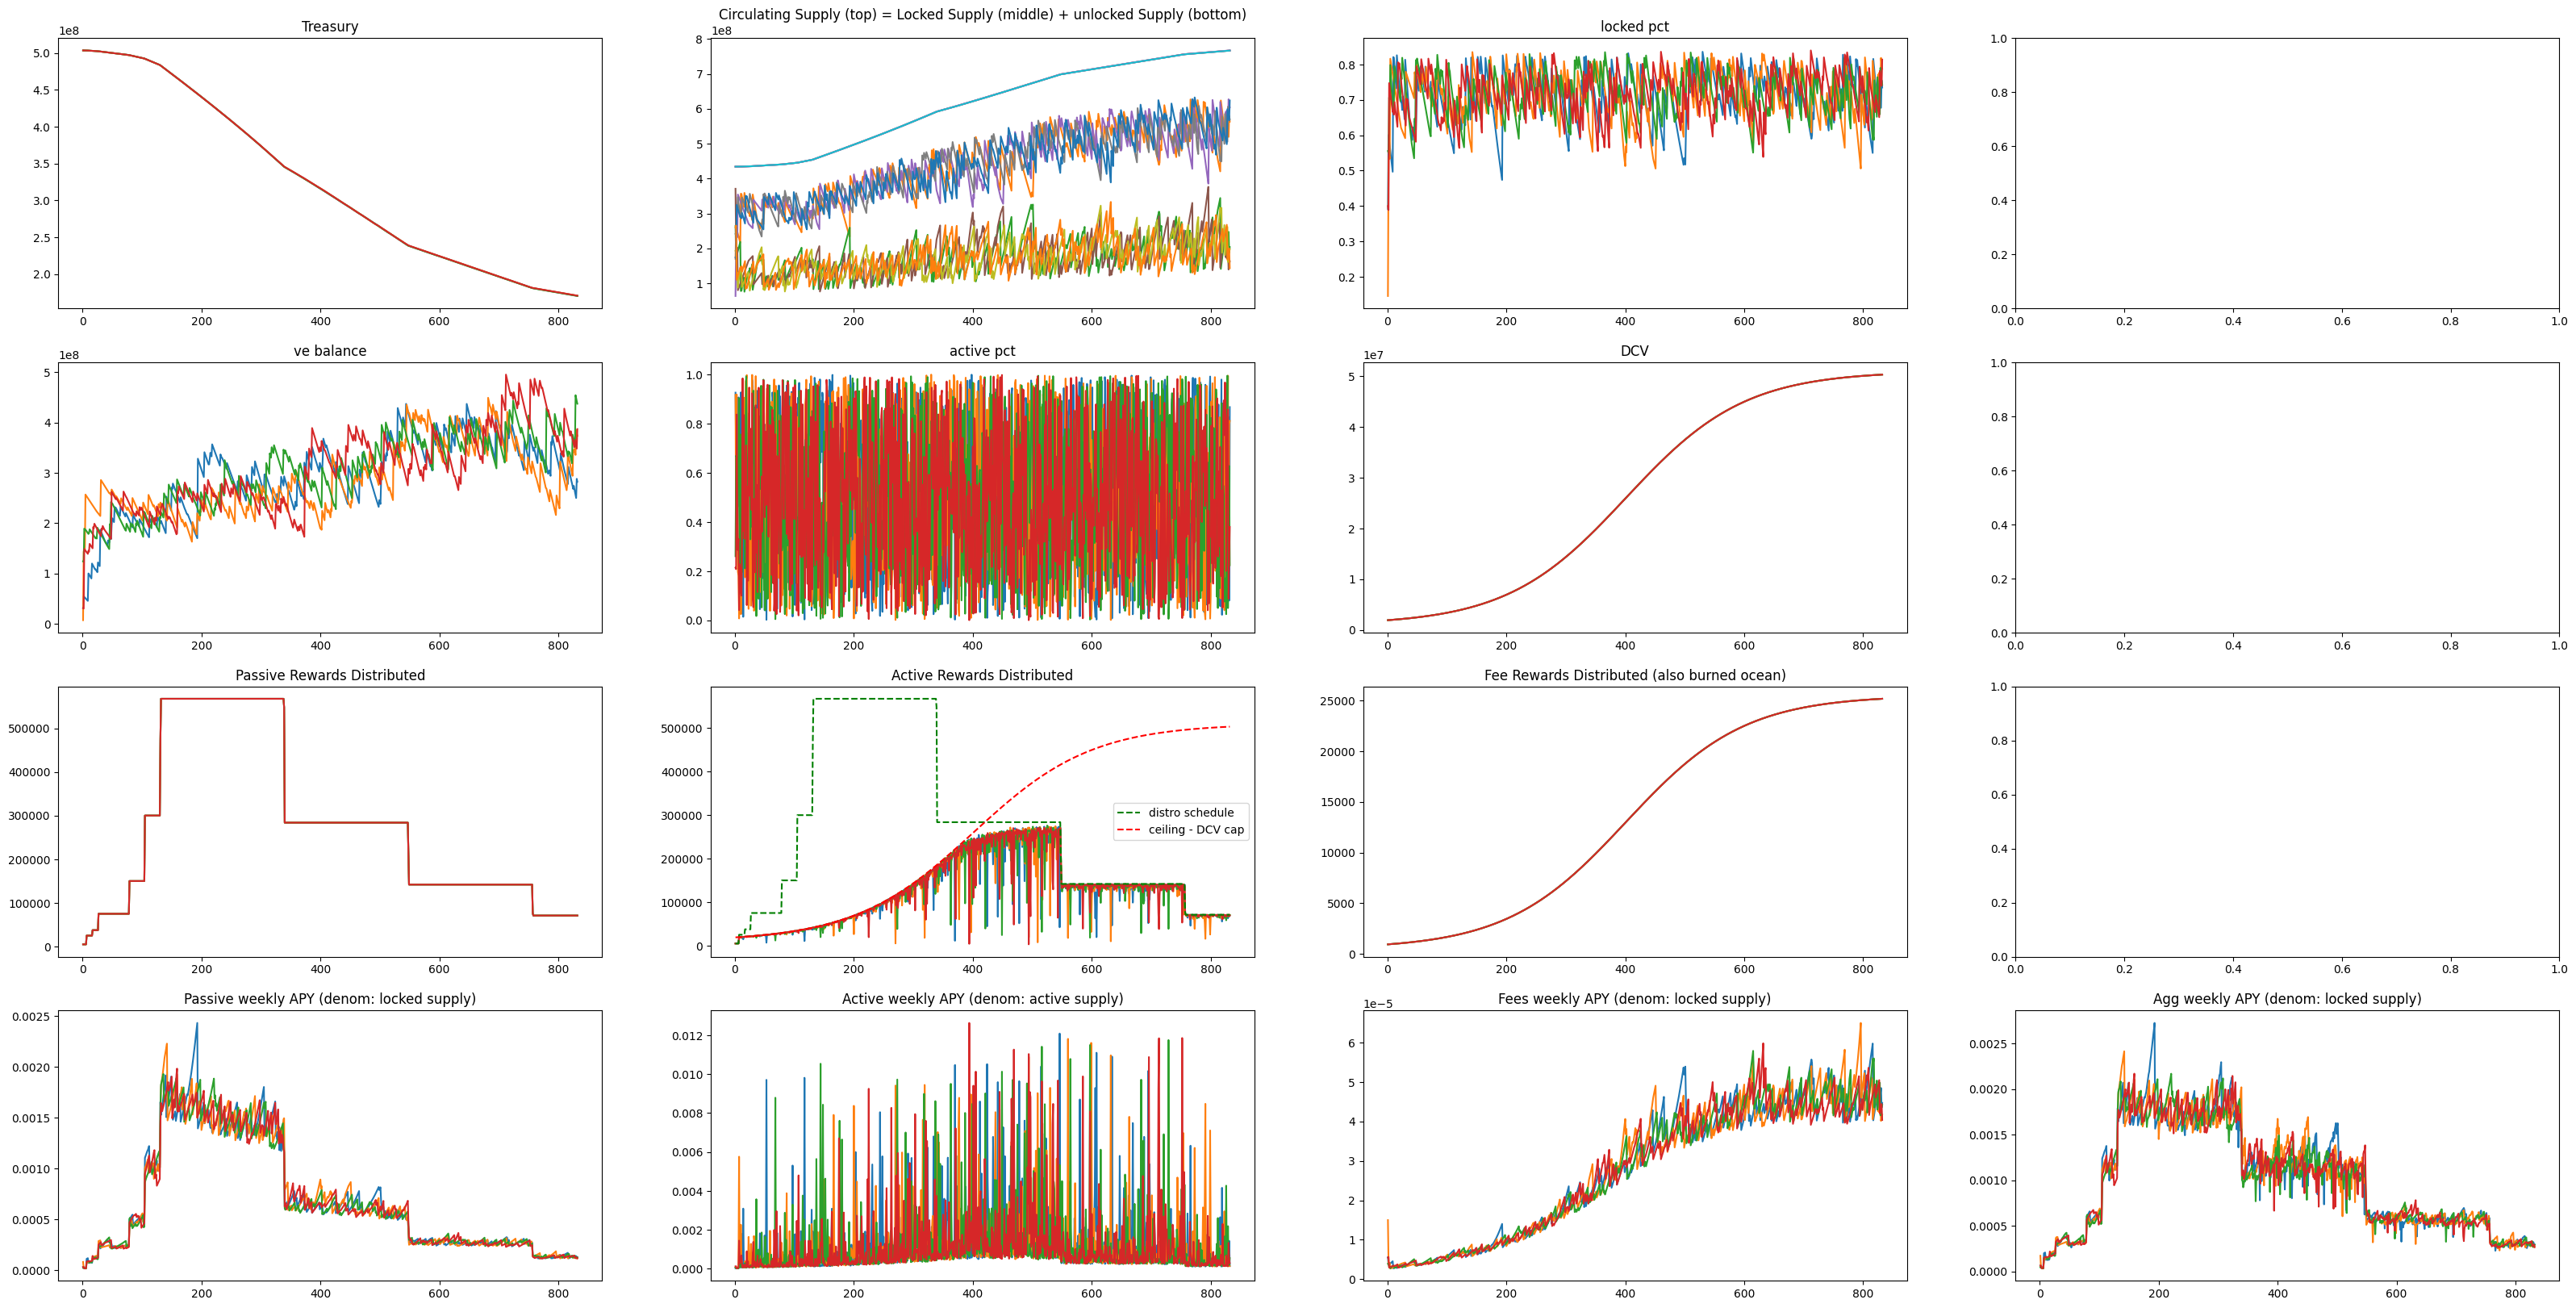

In [4]:
fig, ax = plt.subplots(4,4, figsize=(40,20))
for run in range(1, MONTE_CARLO_RUNS+1):
    df_tmp = df_p[df_p.run == run]
    ax[0,0].plot(df_tmp.timestep, df_tmp.ocean_treasury) # driver: distribution schedule
    ax[0,1].plot(df_tmp.timestep, df_tmp.ocean_unlocked_supply + df_tmp.locked_supply) # driver: distribution schedule & locking behavior
    ax[0,1].plot(df_tmp.timestep, df_tmp.locked_supply) # driver: locking behavior
    ax[0,1].plot(df_tmp.timestep, df_tmp.ocean_unlocked_supply) # driver: locking behavior & unlock decay
    ax[0,2].plot(df_tmp.timestep, df_tmp.pct_locked) # driver: locking behavior (i think we don't see lower % because the unlock decay is slow and takes up timesteps until a higher % is selected)
    ax[1,0].plot(df_tmp.timestep, df_tmp.ve_balance) # driver: locking behavior
    # could plot avg lock duration??? # driver: locking behavior
    ax[1,1].plot(df_tmp.timestep, df_tmp.active_pct) # driver: voting behavior (uniform random)
    # something for asset-level voting success / distribution # driver: voting behavior (uniform random)
    # x = sort by dataconsumevolume, y = pct of veocean allocated to asset
    ax[1,2].plot(df_tmp.timestep, df_tmp.dcv) # driver: DCV growth rate
    ax[2,0].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_passive) # driver: distribution schedule
    ax[2,1].plot(df_tmp.timestep, df_tmp.rewards_distributed_df_active) # driver: distribution schedule & locking behavior & voting behavior (floor: 0% active or 0% voting success & middle: active_pct/voting success & asset-level success/distribution) & Rewards Function (ceiling: DCV*0.1 or 125%APY, therefore DCV growth rate)
    ax[2,2].plot(df_tmp.timestep, df_tmp.rewards_distributed_fees) # driver: DCV growth rate
    ax[3,0].plot(df_tmp.timestep, df_tmp.Passive_APY) #driver: distro schedule & locking behavior
    ax[3,1].plot(df_tmp.timestep, df_tmp.Active_APY) #driver: distro schedule & locking behavior & voting behavior(active pct & asset-level voting success)
    ax[3,2].plot(df_tmp.timestep, df_tmp.Fees_APY) #driver: DCV growth rate & locking behavior
    ax[3,3].plot(df_tmp.timestep, df_tmp.Agg_APY)

ax[2,1].plot(df_p[df_p.run == 1].timestep, df_p[df_p.run == 1].rewards_distributed_df_passive, label='distro schedule', color='green', linestyle='--')
ax[2,1].plot(df_p[df_p.run == 1].timestep, df_p[df_p.run == 1].dcv * 0.01, label='ceiling - DCV cap', color='red', linestyle='--')

ax[0,0].set_title('Treasury')
ax[0,1].set_title('Circulating Supply (top) = Locked Supply (middle) + unlocked Supply (bottom)')
ax[0,2].set_title('locked pct')
ax[1,0].set_title('ve balance')
ax[1,1].set_title('active pct')
#ax[1,2].set_title('something to show uniform random asset-level voting success / distribution')
ax[1,2].set_title('DCV')
ax[2,0].set_title('Passive Rewards Distributed')
ax[2,1].set_title('Active Rewards Distributed')
ax[2,2].set_title('Fee Rewards Distributed (also burned ocean)')
ax[3,0].set_title('Passive APY (denom: locked supply)')
ax[3,1].set_title('Active APY (denom: active supply)')
ax[3,2].set_title('Fees APY (denom: locked supply)')
ax[3,3].set_title('Agg APY (denom: locked supply)')
ax[2,1].legend()
plt.show()

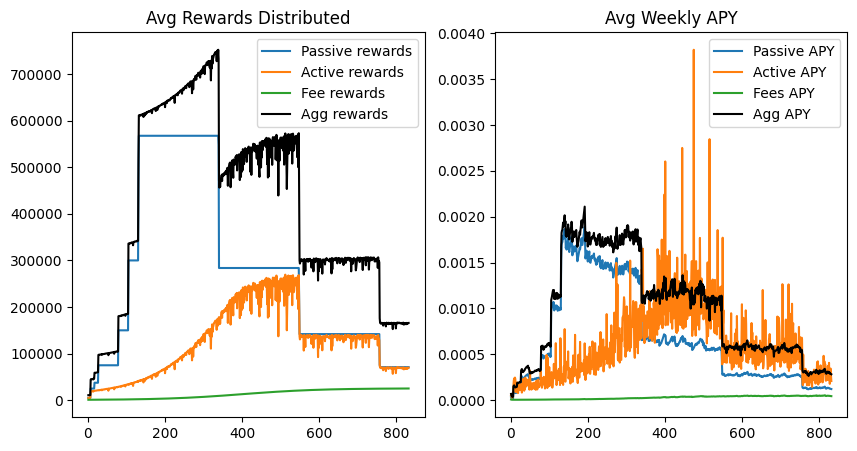

In [43]:
# avg APYs across all runs
df_avg_apy = df_p[['timestep', 'rewards_distributed_df_passive', 'rewards_distributed_df_active', 'rewards_distributed_fees', 'locked_supply', 'active_pct']].reset_index(drop=True)
df_avg_apy = df_avg_apy.groupby('timestep').mean().reset_index()
df_avg_apy['avg_Agg_rewards_distributed'] = df_avg_apy['rewards_distributed_df_passive'] + df_avg_apy['rewards_distributed_df_active'] + df_avg_apy['rewards_distributed_fees']
df_avg_apy['avg_Passive_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_df_passive']/x['locked_supply']/52) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
df_avg_apy['avg_Active_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_df_active']/(x['active_pct']*x['locked_supply'])/52) ** 52 - 1 if x['locked_supply'] != 0 and x['active_pct'] != 0 else 0, axis=1)
df_avg_apy['avg_Fees_APY'] = df_avg_apy.apply(lambda x: (1 + x['rewards_distributed_fees']/x['locked_supply']/52) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)
df_avg_apy['avg_Agg_APY'] = df_avg_apy.apply(lambda x: (1 + (x['rewards_distributed_df_passive'] + x['rewards_distributed_df_active'] + x['rewards_distributed_fees'])/x['locked_supply']/52) ** 52 - 1 if x['locked_supply'] != 0 else 0, axis=1)

fig, ax = plt.subplots(1,2, figsize=(10,5))
#ax[0].plot(df_avg_apy.timestep, df_avg_apy.locked_supply, label='Locked Supply')
ax[0].plot(df_avg_apy.timestep, df_avg_apy.rewards_distributed_df_passive, label='Passive rewards')
ax[0].plot(df_avg_apy.timestep, df_avg_apy.rewards_distributed_df_active, label='Active rewards')
ax[0].plot(df_avg_apy.timestep, df_avg_apy.rewards_distributed_fees, label='Fee rewards')
ax[0].plot(df_avg_apy.timestep, df_avg_apy.avg_Agg_rewards_distributed, label='Agg rewards', color='black')
ax[1].plot(df_avg_apy.timestep, df_avg_apy.avg_Passive_APY, label='Passive APY')
ax[1].plot(df_avg_apy.timestep, df_avg_apy.avg_Active_APY, label='Active APY')
ax[1].plot(df_avg_apy.timestep, df_avg_apy.avg_Fees_APY, label='Fees APY')
ax[1].plot(df_avg_apy.timestep, df_avg_apy.avg_Agg_APY, label='Agg APY', color='black')
ax[0].set_title('Avg Rewards Distributed')
ax[1].set_title('Avg APY')
ax[0].legend()
ax[1].legend()
plt.show()


In [77]:
import plotly.graph_objects as go

run = 1
timestep = 3

df_pw = df_p[df_p.run == run]
df_pw = df_pw[df_pw.timestep == timestep]
y_data = [df_pw.ocean_unlocked_supply.iloc[0][0] + df_pw.locked_supply.iloc[0]
         , -1 * df_pw.ocean_unlocked_supply.iloc[0][0]
         , -1 * df_pw.locked_supply.iloc[0]
         , df_pw.ve_balance.iloc[0]
         , -1 * df_pw.ve_balance.iloc[0] * df_pw.active_pct.iloc[0]
         , -1 * df_pw.ve_balance.iloc[0] * (1 - df_pw.active_pct.iloc[0])]



fig = go.Figure(go.Waterfall(
    name = "Ocean Supply", orientation = "v",
    measure = ["relative", "relative", "relative", "relative", "relative", "relative"],
    x = ["Circulating Supply", "Unlocked", "Locked", "veBalance", "Active (vote on ranked asset)", "Passive"],
    textposition = "outside",
    #text = ["Circulating Supply", "Unlocked", "Locked", "veBalance", "Active (vote on ranked asset)", "Passive"],
    y = y_data,
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
        title = f"Ocean Token Supply Waterfall Chart run {run} timestep {timestep}",
        showlegend = True
)

fig.show()

In [68]:
# vote distributuion Run X, Timestep X
# df_pw.data_assets.iloc[0]

### model verification analysis:
- Treasury decreases according to the distribution schedule
- circulating supply increases according to the distribution schedule
- Locked & Unlocked supply are volatile because of locking behavior & the unlock decay of the ve mechanism (see locked pct), but trend upwards with circulating supply
- Locked pct is not uniform (0-100%) despite that assumption/implementation because the unlock decay takes time and a higher % ends up selected before it can decay much
- ve balance trends upward along with locked supply, but is also influenced by lock duration (which should be uniform random 1 week - 4 years)
- Active pct is uniform random! because voting behavior changes every timestep with no restrictions or time delays
- Passive rewards distributed according to distribution schedule
- active rewards distributed according to the distribution schedule but also depend on locking/voting behavior (i.e. active_pct&asset-level distribution (which is random uniform)). Plus the ceiling (DCV or APY) implemented in the rewards function. Therefore also the DCV growth rate
- Fee rewards distribution depends on DCV growth rate

APYs!
- Passive: volatile because locking behavior influences locked supply. What looks like a lower bound is due to the 85% cap to locked supply which limits the dilution effect
- Active: volatile because locking behavior influences locking supply & voting behavior influences active supply/asset-level distribution. plus there is a ceiling on rewards distributed (DCV*0.1 & 125% APY) implemented in the rewards function
- Fees: volatile because locking behavior influences locked supply.

Conclusion:
- according to this model, this token model will not incentivize locking Ocean enough in the short & long-term. APY is too low initially when it's mainly passive_APY, also even after DCV is no longer a ceiling for Active rewards the APY is still low & decreases further because protocol revenues remain low.

Next-steps:
- Everything in this model is denominated in $Ocean - would considering an external $Ocean price change anything? 
- could improve locking behavior: either change the implementation so that it is actually uniform random (not sure how), or treat it with a starting value & growth rate
- could improve voting behavior: 1. could assume perfect strategies to get a true ceiling for perspective/reference 2. could be more complete with the analysis by calculating Active_APY for every possible voting outcome and then (assuming every outcome is =likely) create a probability distrobution of active rewards given a certain locked supply (note, this would still depend on locking behavior)

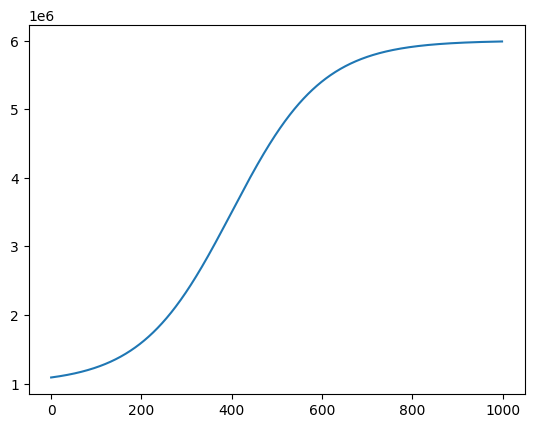

In [12]:
x = np.arange(0, 1000)
y = lambda x: 0.005*((1+0.2*((1-0.05)**x))**x) #exponential increase/decrease
y2 = lambda x: 5*(1e6 / (1 + np.exp(-(1/100)*(x - 400)))) + 1e6 #sigmoid
y3 = lambda x: 1000000*(1+0.1)**(0.1*x)



plt.plot(x,y2(x))
